# Table E13
##  Logistic regression and Cox model with image-expression axes (IEAs) and PCA Image Only Axes (PCA-Is) on COPDGene visit 1 data. 
The table reports the β coefficients, the odds/hazard ratio, and the corresponding 95% confidence interval in logistic regression and the Cox model to estimate the frequent exacerbator and mortality. We included the models with PCA-Is + IEAs and the models with PCA-I only and reported the p-values of the likelihood ratio test.

In [1]:
import numpy as np
import sys
sys.path.append("../../src/")
import utility
import pandas as pd

from matplotlib import pyplot as plt
from scipy.stats import pearsonr
from scipy.stats import ttest_ind

from scipy.stats import kruskal
from statsmodels.stats.proportion import proportions_chisquare

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib

import statsmodels.api as sm

from scipy import stats

import pandas as pd

import math

from lifelines import CoxPHFitter


# Loading data

In [2]:
df_IEA_P1 = pd.read_csv("../../output/IEA_P1.csv").set_index("sid")
df_data = utility.load_data()
df_PCs = utility.load_SSL_PCs()

df_merged = pd.merge(df_IEA_P1, df_data, left_index = True, right_index = True)
df_used = pd.merge(df_merged, df_PCs, left_index = True, right_index = True)



/ocean/projects/asc170022p/juc91/anaconda/envs/IEA/lib/python3.7/site-packages/pandas/core/generic.py:8870: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
../../src/utility.py:168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cov[df_cov == ""] = "nan"
/ocean/projects/asc170022p/juc91/anaconda/envs/IEA/lib/python3.7/site-packages/pandas/core/frame.py:3718: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

# Logistic regression with both IEAs and PCA-I

In [3]:
independents = ["IEA0", "IEA1", "PC0_P1", "PC1_P1"]


models_IEA = []


In [4]:
p_values = []

cov_dict_IEA = {iii:[] for iii in independents}
exp_cov_dict_IEA = {iii:[] for iii in independents}
            
    
for ccc in ["Frequent_Exacerbator_P1", "Frequent_Exacerbator_P2"]:
    X = df_used[independents
               ]
        
    y = df_used[ccc]
    idx = np.bitwise_and(~np.isnan(y), ~np.isnan(X).any(1))
    
    X = X[idx]
    y = y[idx]
    
    X = sm.add_constant(X.apply(stats.zscore))
    
    
    M_logit = sm.Logit(y, X).fit()

    models_IEA.append(M_logit)

    
    
    v = M_logit.summary2().tables[1].values
    
    
    for iii in range(1, len(independents) + 1):
        col = independents[iii-1]
        eee = "{:.2f}".format(v[iii, 0])
        ppp = v[iii, 3]
        if ppp<.05:
            eee += "*"
        if ppp<.01:
            eee += "*"
        if ppp<.001:
            eee += "*"
            
        CI1 = "\n({:.2f}, {:.2f})".format(v[iii, 4], v[iii, 5])
        
        cov_dict_IEA[col].append(eee + CI1)

        
        col = independents[iii-1]
        eee = "{:.2f}".format( np.exp( v[iii, 0]) )
        ppp = v[iii, 3]
        if ppp<.05:
            eee += "*"
        if ppp<.01:
            eee += "*"
        if ppp<.001:
            eee += "*"
            
        CI2 = "\n({:.2f}, {:.2f})".format( np.exp(v[iii, 4]), np.exp(v[iii, 5]))
        
        exp_cov_dict_IEA[col].append(eee + CI2)
        
    

Optimization terminated successfully.
         Current function value: 0.282805
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.256887
         Iterations 7


# Cox proportional harzard model with both IEAs and PCA-I

In [5]:
df_survival = df_used[ ["days_followed", "vital_status"] + independents ]

df_survival = df_survival[~df_survival.isnull().any(1)]
df_survival[ independents ] = df_survival[ independents ].apply(stats.zscore)

M = CoxPHFitter(penalizer = 0., l1_ratio=0.5)
M.fit(df_survival, duration_col = "days_followed", event_col = "vital_status")


models_IEA.append(M)

v = M.summary

for col in v.index:
    eee = "{:.2f}".format( v.loc[col, "coef"] )
    ppp =  v.loc[col, "p"]
    if ppp<.05:
        eee += "*"
    if ppp<.01:
        eee += "*"
    if ppp<.001:
        eee += "*"

    CI1 = "\n({:.2f}, {:.2f})".format(v.loc[col, "coef lower 95%"], v.loc[col, "coef upper 95%"])

    cov_dict_IEA[col].append(eee + CI1)

    eee = "{:.2f}".format( np.exp( v.loc[col, "coef"] ) )
    ppp =  v.loc[col, "p"]
    if ppp<.05:
        eee += "*"
    if ppp<.01:
        eee += "*"
    if ppp<.001:
        eee += "*"

    CI2 = "\n({:.2f}, {:.2f})".format( np.exp( v.loc[col, "coef lower 95%"]), np.exp(v.loc[col, "coef upper 95%"]))

    exp_cov_dict_IEA[col].append(eee + CI2)
    

# Logistic regression with PCA-I only

In [6]:
independents = ["PC0_P1", "PC1_P1"]


models_PC = []


In [7]:
p_values = []

cov_dict_PC = {iii:[] for iii in independents}
exp_cov_dict_PC = {iii:[] for iii in independents}
            
    
for ccc in ["Frequent_Exacerbator_P1", "Frequent_Exacerbator_P2"]:
    X = df_used[independents
               ]
        
    y = df_used[ccc]
    idx = np.bitwise_and(~np.isnan(y), ~np.isnan(X).any(1))
    
    X = X[idx]
    y = y[idx]
    
    X = sm.add_constant(X.apply(stats.zscore))
    
    
    M_logit = sm.Logit(y, X).fit()

    models_PC.append(M_logit)

    
    
    v = M_logit.summary2().tables[1].values
    
    
    for iii in range(1, len(independents) + 1):
        col = independents[iii-1]
        eee = "{:.2f}".format(v[iii, 0])
        ppp = v[iii, 3]
        if ppp<.05:
            eee += "*"
        if ppp<.01:
            eee += "*"
        if ppp<.001:
            eee += "*"
            
        CI1 = "\n({:.2f}, {:.2f})".format(v[iii, 4], v[iii, 5])
        
        cov_dict_PC[col].append(eee + CI1)

        
        col = independents[iii-1]
        eee = "{:.2f}".format( np.exp( v[iii, 0]) )
        ppp = v[iii, 3]
        if ppp<.05:
            eee += "*"
        if ppp<.01:
            eee += "*"
        if ppp<.001:
            eee += "*"
            
        CI2 = "\n({:.2f}, {:.2f})".format( np.exp(v[iii, 4]), np.exp(v[iii, 5]))
        
        exp_cov_dict_PC[col].append(eee + CI2)
        
    

Optimization terminated successfully.
         Current function value: 0.296258
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.264688
         Iterations 7


# Cox proportional harzard model with PCA-I only

In [8]:
df_survival = df_used[ ["days_followed", "vital_status"] + independents ]

df_survival = df_survival[~df_survival.isnull().any(1)]
df_survival[ independents ] = df_survival[ independents ].apply(stats.zscore)

M = CoxPHFitter(penalizer = 0., l1_ratio=0.5)
M.fit(df_survival, duration_col = "days_followed", event_col = "vital_status")


models_PC.append(M)

v = M.summary

for col in v.index:
    eee = "{:.2f}".format( v.loc[col, "coef"] )
    ppp =  v.loc[col, "p"]
    if ppp<.05:
        eee += "*"
    if ppp<.01:
        eee += "*"
    if ppp<.001:
        eee += "*"

    CI1 = "\n({:.2f}, {:.2f})".format(v.loc[col, "coef lower 95%"], v.loc[col, "coef upper 95%"])

    cov_dict_PC[col].append(eee + CI1)

    eee = "{:.2f}".format( np.exp( v.loc[col, "coef"] ) )
    ppp =  v.loc[col, "p"]
    if ppp<.05:
        eee += "*"
    if ppp<.01:
        eee += "*"
    if ppp<.001:
        eee += "*"

    CI2 = "\n({:.2f}, {:.2f})".format( np.exp( v.loc[col, "coef lower 95%"]), np.exp(v.loc[col, "coef upper 95%"]))

    exp_cov_dict_PC[col].append(eee + CI2)
    

# Computing p-values for likelihood ratio test

In [9]:
from scipy.stats.distributions import chi2


p_values = []

for iii in range(3):
    mmm = models_IEA[iii]
    lll = models_PC[iii]
    
    if iii == 2:
        ll0 = lll.log_likelihood_
        ll1 = mmm.log_likelihood_
        
        dg0 = 2
        dg1 = 4
    else:       
        ll0 = lll.llf
        ll1 = mmm.llf
        dg0 = lll.df_model
        dg1 = mmm.df_model
    
    chi2_stat = -2 * (ll0-ll1)
    p = chi2.sf(chi2_stat, dg1-dg0)
    
    p_values.append( p )

p_values_str = []
for iii in p_values:
    if iii < .001:
        p_values_str.append("<.001")
    else:
        p_values_str.append("{:.3f}".format(iii))
        
p_values_str = np.array(p_values_str)[:, None]

# Tables for the likelihood ratio test

In [10]:
rows = ["Frequent Exacerbator (History)", "Frequent Exacerbator (Future)", "Mortality"
       ]

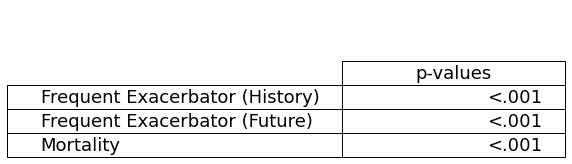

In [11]:
fig, ax = plt.subplots(figsize=(2,1))

the_table=plt.table(cellText = p_values_str, rowLabels = rows, 
                    colLabels = ["p-values"])

plt.axis('off')

the_table.auto_set_font_size(False)
the_table.set_fontsize(18)
the_table.scale(2, 2)

# Table for beta coeffcients ( PCA-I  )

In [12]:
independents = ["PC0_P1", "PC1_P1"]

cov_label = ["PCA-I1", "PCA-I2"]

In [13]:
table = np.array( [ [cov_dict_PC[ccc][iii] for ccc in independents] for iii in range(len(models_PC))  ] )

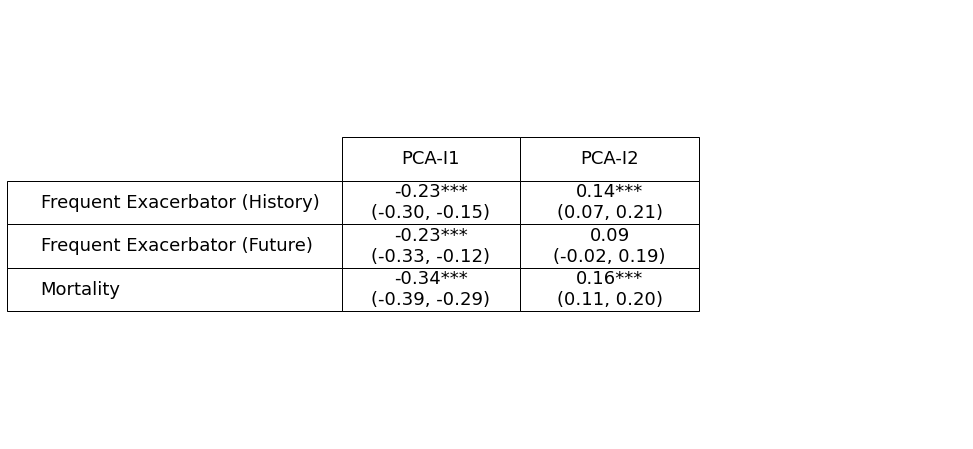

In [14]:
fig, ax = plt.subplots(figsize=(16,8))

the_table=plt.table(cellText=table, rowLabels=rows,
                    colLabels = cov_label,
                     colWidths = [.1]*table.shape[1], loc='center', fontsize = 50, cellLoc = "center"
                   )

plt.axis('off')

the_table.auto_set_font_size(False)
the_table.set_fontsize(18)
the_table.scale(2, 2)

for iii in range(table.shape[0] + 1):
    for jjj in range(-1, table.shape[1]):
        if not (iii == 0 and jjj == -1) :
            the_table[(iii,jjj)].set_height(.1)
    

# Table for Odds / Hazard Ratio (  PCA-I )

In [15]:
table = np.array( [ [exp_cov_dict_PC[ccc][iii] for ccc in independents] for iii in range(len(models_PC))  ] )

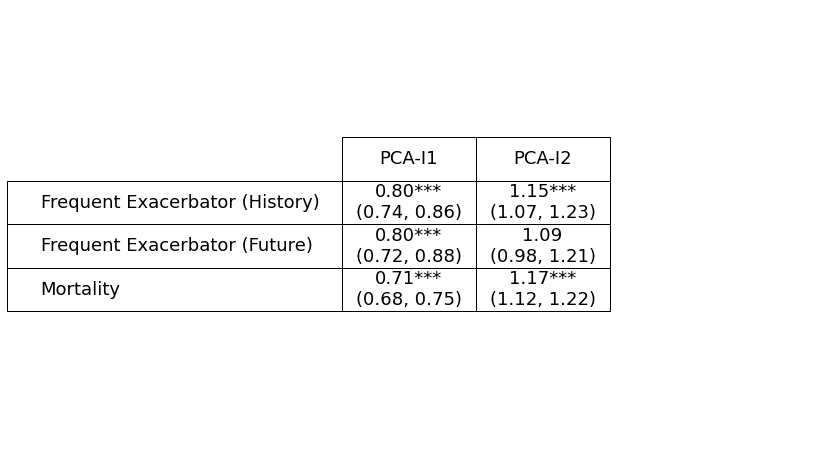

In [16]:
fig, ax = plt.subplots(figsize=(12,8))

the_table=plt.table(cellText=table, rowLabels=rows,
                    colLabels = cov_label,
                     colWidths = [.1]*table.shape[1], loc='center', fontsize = 50, cellLoc = "center"
                   )

plt.axis('off')

the_table.auto_set_font_size(False)
the_table.set_fontsize(18)
the_table.scale(2, 2)

for iii in range(table.shape[0] + 1):
    for jjj in range(-1, table.shape[1]):
        if not (iii == 0 and jjj == -1) :
            the_table[(iii,jjj)].set_height(.1)
    

# Table for beta coeffcients (  PCA-I + IEAs  )

In [17]:
independents = ["IEA0", "IEA1", "PC0_P1", "PC1_P1"]

cov_label = [ "IEA$_{emph}$", "IEA$_{airway}$", "PCA-I1", "PCA-I2"]

In [18]:
table = np.array( [ [cov_dict_IEA[ccc][iii] for ccc in independents] for iii in range(len(models_IEA))  ] )

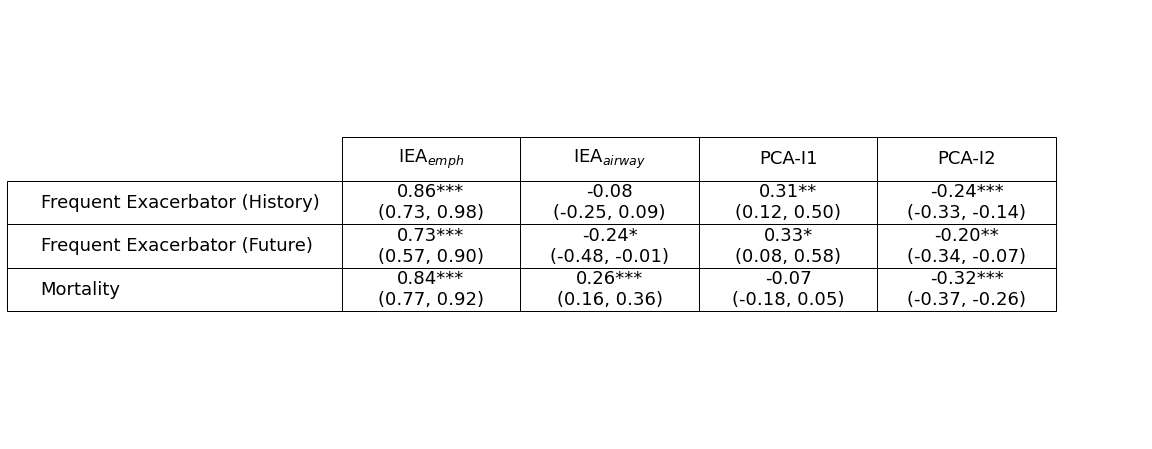

In [19]:
fig, ax = plt.subplots(figsize=(16,8))

the_table=plt.table(cellText=table, rowLabels=rows,
                    colLabels = cov_label,
                     colWidths = [.1]*table.shape[1], loc='center', fontsize = 50, cellLoc = "center"
                   )

plt.axis('off')

the_table.auto_set_font_size(False)
the_table.set_fontsize(18)
the_table.scale(2, 2)

for iii in range(table.shape[0] + 1):
    for jjj in range(-1, table.shape[1]):
        if not (iii == 0 and jjj == -1) :
            the_table[(iii,jjj)].set_height(.1)
    

# Table for Odds / Hazard Ratio (  PCA-I + IEAs)

In [20]:
table = np.array( [ [exp_cov_dict_IEA[ccc][iii] for ccc in independents] for iii in range(len(models_IEA))  ] )

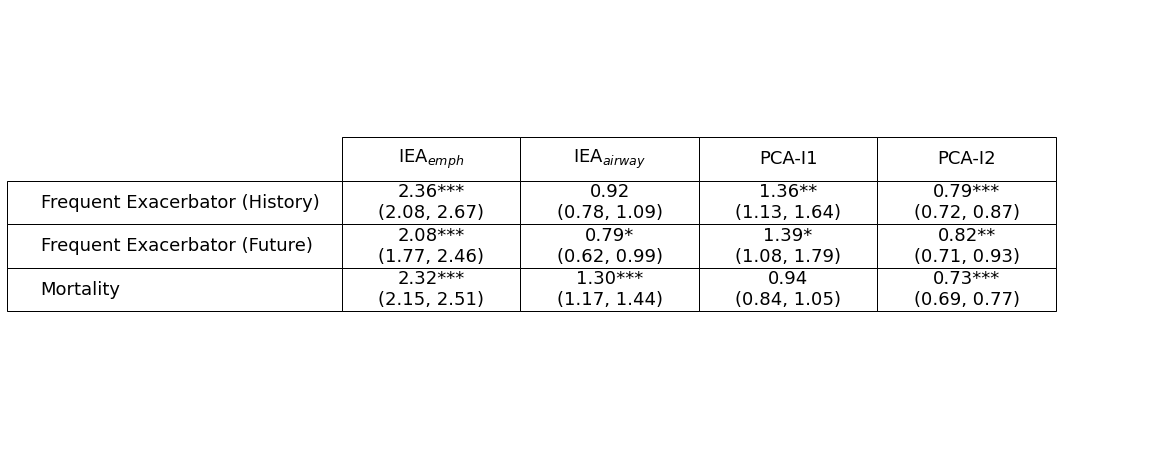

In [21]:
fig, ax = plt.subplots(figsize=(16,8))

the_table=plt.table(cellText=table, rowLabels=rows,
                    colLabels = cov_label,
                     colWidths = [.1]*table.shape[1], loc='center', fontsize = 50, cellLoc = "center"
                   )

plt.axis('off')

the_table.auto_set_font_size(False)
the_table.set_fontsize(18)
the_table.scale(2, 2)

for iii in range(table.shape[0] + 1):
    for jjj in range(-1, table.shape[1]):
        if not (iii == 0 and jjj == -1) :
            the_table[(iii,jjj)].set_height(.1)
    